In [1]:
import sympy as sp
import numpy as np
from functools import reduce
from itertools import accumulate
import operator
import time

In [2]:
def compute_all_thetas(theta0, utheta):
    return theta0 + np.cumsum(utheta)

def compute_all_vs(v0, accels_uncertain, dt):
    return v0 + dt*np.cumsum(accels_uncertain)

def compute_beta2_mono_moments(alpha, beta, monos):
    max_order_needed = max([sum(list(mono)) for mono in monos])
    #assume iid beta moments
    beta2_moments = compute_betacoeff_moments(alpha,beta,max_order_needed,2)
    cross_moments = [reduce(lambda prev,ni: prev*beta2_moments[ni],[1] + list(tup)) for tup in monos]
    return cross_moments

def compute_beta2_coef_mono_moments(alpha, beta, monos,coefs):
    max_order_needed = max([sum(list(mono)) for mono in monos])
    #assume iid beta moments
    beta2_moments = compute_beta2_moments(alpha,beta,max_order_needed)
    
    tup_coef_map = {tup:tup_coef(tup, coefs) for tup in monos}
    
    cross_moments = [tup_coef_map[tup]*reduce(lambda prev,ni: prev*beta2_moments[ni],[1] + list(tup)) for tup in monos]
    return cross_moments

def tup_coef(tup,coefs):
    #Tuple in format (0,0,0,2,0,0,0)
    #coefs in format [1,1,1,1,1,1,1]
    #Find indicies of non-zero tups
    relevant_indices = [tup.index(i) for i in tup if i>0]
    coef = reduce(operator.mul, [coefs[i]**tup[i] for i in relevant_indices],1)
    return coef

def compute_beta_moments(alpha,beta,order):
    #Compute beta moments up to the given order
    #the returned list indices should match the moment orders
    #e.g. the return[i] should be the ith beta moment
    fs = map(lambda r: (alpha + r)/(alpha + beta + r), range(order))
    return [1] + list(accumulate(fs, lambda prev,n: prev*n))

def compute_beta2_moments(alpha, beta, n):
    beta_moments = compute_beta_moments(alpha, beta, n)
    return [beta_moments[i]*2**i for i in range(len(beta_moments))]

def compute_betacoeff_moments(alpha, beta, n, coeff):
    #Let w be a beta random variable with params alpha and beta
    #this function computes the first n moments of cw where c is some coefficient
    beta_moments = compute_beta_moments(alpha, beta, n)
    return [beta_moments[i]*coeff**i for i in range(len(beta_moments))]

def chebyshev_bound(first_moment, second_moment):
    #bound the probability that p<=0
    if first_moment<=0:
        return None
    else:
        variance = second_moment - first_moment**2
        return variance/(variance + first_moment**2)
    
    
def dubins_accel_noise(dt, n_t, p):
    #Initial x and y
    xc = sp.symbols('xc', real = True, constant = True)
    yc = sp.symbols('yc', real = True, constant = True)

    Cw = sp.symbols('Cw0:' + str(n_t-1), real = True, constant = True)
    Sw = sp.symbols('Sw0:' + str(n_t-1), real = True, constant = True)

    xs_final = xc + dt*sum([Cw[i] for i in range(n_t-1)])
    ys_final = yc + dt*sum([Sw[i] for i in range(n_t-1)])

    allvars = Cw + Sw

    thang = p(xs_final, ys_final)

    final_p = sp.poly(sp.expand(thang),allvars)
    final_p_sq = final_p**2

    coefs_p = np.asarray(final_p.coeffs())
    monos_p = final_p.monoms()

    coefs_p_sq = np.asarray(final_p_sq.coeffs())
    monos_p_sq = final_p_sq.monoms()
    
    #We will can coefs with control input data and monos with moments now!
    coefs_p_lam = sp.lambdify([xc, yc], coefs_p, 'numpy') #now a function that accepts two lists as inputs
    coefs_p_sq_lam = sp.lambdify([xc, yc], coefs_p_sq, 'numpy') #now a function that accepts two lists as inputs

    return [(coefs_p_lam, monos_p), (coefs_p_sq_lam, monos_p_sq)]

def post_process(x0,y0,theta0,v0,coefs_p_lam,coefs_p_sq_lam,monos_p,monos_p_sq,n_t):
    #We can use monos_p and monos_p_sq to determine the moments we need given any uncertain vector with independent elements
    alpha = 500
    beta = 550

    start_t = time.time()

    #Generate simple control sequence
    ua_vals = np.ones((1,n_t)).ravel().tolist()
    cos_theta_vals = np.ones((1,n_t)).ravel().tolist()
    sin_theta_vals = np.zeros((1,n_t)).ravel().tolist()

    xcval = x0 + dt*v0*sum(cos_theta_vals)
    ycval = y0 + dt*v0*sum(sin_theta_vals)

    Cis = []
    Sis = []
    for i in range(n_t-1):
        Cis.append(ua_vals[i]*sum(cos_theta_vals[i+1:n_t+1]))
        Sis.append(ua_vals[i]*sum(sin_theta_vals[i+1:n_t+1]))

    mono_coefs = Cis + Sis

    #Calculate them moments
    mono_moments_p = np.asarray(compute_beta2_coef_mono_moments(alpha, beta, monos_p,mono_coefs)) #these moments correspond to the monos
    mono_moments_p_sq = np.asarray(compute_beta2_coef_mono_moments(alpha, beta, monos_p_sq,mono_coefs)) #these moments correspond to the monos

    #Calculate them coefficients
    coef_p_vals = coefs_p_lam(xcval,ycval)
    coef_psq_vals = coefs_p_sq_lam(xcval,ycval)

    #Calculate them moments of p
    p_first_moment = np.dot(mono_moments_p, coef_p_vals)
    p_second_moment = np.dot(mono_moments_p_sq, coef_psq_vals)



    risk_bound = chebyshev_bound(p_first_moment, p_second_moment)


    print("first moment of p is: " + str(p_first_moment))
    print("second moment of p is: " + str(p_second_moment))
    variance = p_second_moment - p_first_moment**2
    print("variance is: " + str(variance))
    print("risk bound is: " + str(risk_bound))
    
    end_t = time.time()
    print("Online solve step time to solve: " + str(end_t - start_t))

In [ ]:
# Integration time step
dt = 0.05

# Initial Conditions
x0 = -10.0
y0 = 0.0
theta0 = 0.0
v0 = 1.0

# The polynomial that defines the obstacle set
p = lambda x,y: -2*x**2 - 4*y**2 + 3*y**4 + 2.0*x**4 - 0.1

# Compute stochastic verification functions for each time step
for n_t in range(2,11):
    start_t_preprocess = time.time()
    res = dubins_accel_noise(dt, n_t, p)
    coefs_p_lam = res[0][0]
    coefs_p_sq_lam = res[1][0]
    monos_p = res[0][1]
    monos_p_sq = res[1][1]
    end_t_preprocess = time.time()
    print("For n_t = " + str(n_t))
    print("Number of monos in monos_p_sq  is: " + str(len(monos_p_sq)))
    print("Time for pre-process is: " + str(end_t_preprocess - start_t_preprocess))
    post_process(x0,y0,theta0,v0,coefs_p_lam,coefs_p_sq_lam,monos_p,monos_p_sq,n_t)

For n_t = 2
Number of monos in monos_p_sq  is: 33
Time for pre-process is: 0.09031486511230469
first moment of p is: 18650.7048216614
second moment of p is: 347848927.79289955
variance is: 137.44815582036972
risk bound is: 3.9513750032946163e-07
Online solve step time to solve: 0.0007538795471191406
For n_t = 3
Number of monos in monos_p_sq  is: 285
Time for pre-process is: 0.24159932136535645
first moment of p is: 17580.0656000503
second moment of p is: 309607423.1971444
variance is: 548716.6950724721
risk bound is: 0.0017722982524326408
Online solve step time to solve: 0.0008180141448974609
For n_t = 4
Number of monos in monos_p_sq  is: 1485
Time for pre-process is: 0.4620938301086426
first moment of p is: 16263.565145509248
second moment of p is: 267314856.2709692
variance is: 2811305.0287459493
risk bound is: 0.010516830482089675
Online solve step time to solve: 0.004476308822631836
For n_t = 5
Number of monos in monos_p_sq  is: 5750
Time for pre-process is: 1.4744062423706055
firs

first moment of p is: 17244.519508339734
second moment of p is: 299143926.2622607
variance is: 1770473.188751042
risk bound is: 0.005918466107176988
Total time to solve: 0.008388996124267578


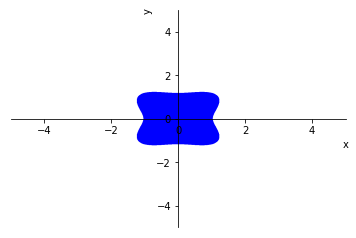

In [5]:
%matplotlib inline
sp.var('x y')
sp.plot_implicit(-2*x**2 - 4*y**2 + 3*y**4 + 2.0*x**4 - 0.1<=0)